<a href="https://colab.research.google.com/github/battleship0000/lab-assignemnt--3-Ritik-Bhandari---2301201151-Sec-B/blob/main/LAB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Problem 1: Friend Suggestion (BFS-style) ===
Suggestions for A (candidate, mutual_count, mutual_friends):
  ('D', 1, ['B'])
  ('E', 1, ['C'])
Time complexity: O(V + E) for neighborhood exploration (practical cost: deg(user) + neighbors' degrees).

=== Problem 2: Bellman-Ford (Route Finding with negative edges) ===
Distances from source 0: [0.0, -2.0, 4.0, 1.0, 6.0]
Negative-weight cycle detected?: False
Elapsed: 0.000039s, Peak mem: 0.2 KB
Complexity: O(V * E)

=== Problem 3: Dijkstra (Emergency route times) ===
Shortest distances from node 0: {0: 0.0, 1: 3.0, 2: 1.0, 3: 4.0}
Elapsed: 0.000037s, Peak mem: 0.6 KB
Complexity: O(E log V)
Note: Dijkstra requires non-negative weights; otherwise Bellman-Ford is needed.

=== Problem 4: MST (Prim & Kruskal) ===
Kruskal MST edges: [(0, 1, 2), (1, 2, 3), (1, 4, 5), (0, 3, 6)]
Kruskal total cost: 16.0
Kruskal elapsed: 0.000036s, peak mem: 0.7 KB
Prim MST edges: [(0, 1, 2), (1, 2, 3), (1, 4, 5), (0, 3, 6)]
Prim total cost: 16.0
Prim elapsed: 0

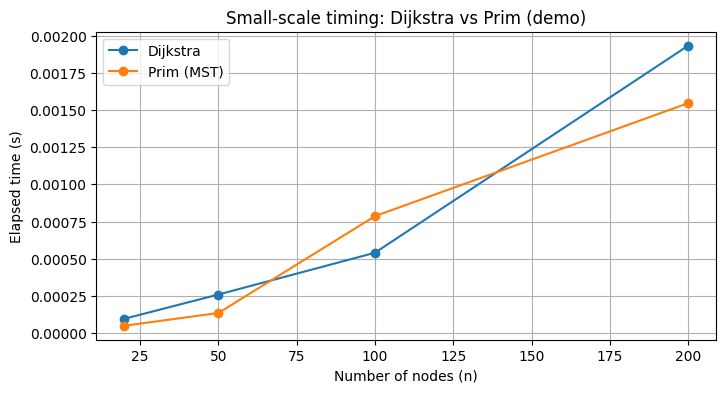

=== Profiling summary (small-scale demo) ===
n=20: Dijkstra time=0.000096s, peak_mem=4.5 KB | Prim time=0.000049s, peak_mem=3.0 KB
n=50: Dijkstra time=0.000259s, peak_mem=8.5 KB | Prim time=0.000135s, peak_mem=3.3 KB
n=100: Dijkstra time=0.000540s, peak_mem=23.4 KB | Prim time=0.000786s, peak_mem=13.1 KB
n=200: Dijkstra time=0.001932s, peak_mem=52.6 KB | Prim time=0.001546s, peak_mem=60.5 KB

=== Final Summary ===
Problem 1 (Social suggestions) : BFS/neighbor-exploration, complexity O(V + E) in neighborhood scanning.
Problem 2 (Routing)            : Bellman-Ford, handles negative weights, complexity O(V * E).
Problem 3 (Emergency routing)  : Dijkstra (min-heap), complexity O(E log V).
Problem 4 (Cable installation) : MST via Prim or Kruskal, complexity O(E log V) / O(E log E).
Plot produced: small-scale timing comparison for Dijkstra and Prim (visual).

Notes:
- For memory profiling on larger runs, consider using `memory_profiler` package (requires pip install).
- For large real networ

In [3]:
import time
import tracemalloc
import heapq
import random
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from typing import Dict, List, Tuple

SAVE_PLOTS = False
PLOT_DIR = "/content/plots"

# -----------------------
# Utility: measure time + peak memory (tracemalloc)
# -----------------------
def measure(func, *args, **kwargs):
    """Run func(*args, **kwargs). Return (result, elapsed_seconds, peak_mem_kb)."""
    tracemalloc.start()
    t0 = time.perf_counter()
    res = func(*args, **kwargs)
    elapsed = time.perf_counter() - t0
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_kb = peak / 1024.0
    return res, elapsed, peak_kb

# -----------------------
# Problem 1: Social Network Friend Suggestion (BFS-based)
# -----------------------
# Given an undirected adjacency list, suggest friends-of-friends for a user,
# rank by number of mutual friends (descending), exclude existing friends and self.

def suggest_friends(adj: Dict[str, List[str]], user: str, k: int = 10):
    """
    Return list of (candidate, mutual_count, mutual_friends_list).
    Uses BFS/neighbor exploration to find friends-of-friends.
    Complexity: O(V + E) to traverse neighbors of user (plus sorting result).
    """
    if user not in adj:
        return []

    user_friends = set(adj[user])
    visited = set([user])  # avoid recommending self
    suggestions = defaultdict(lambda: {"mutual": 0, "mutual_list": []})

    # For each friend, look at their friends
    for f in user_friends:
        for fof in adj.get(f, []):
            if fof == user:
                continue
            if fof in user_friends:
                # already friend, skip
                continue
            suggestions[fof]["mutual"] += 1
            suggestions[fof]["mutual_list"].append(f)

    # convert to sorted list by mutual count desc, then by name
    results = sorted(
        [(cand, info["mutual"], list(set(info["mutual_list"])))
         for cand, info in suggestions.items()],
        key=lambda x: (-x[1], x[0])
    )
    return results[:k]

# Example small network
adj_example = {
    "A": ["B", "C"],
    "B": ["A", "C", "D"],
    "C": ["A", "B", "E"],
    "D": ["B", "F"],
    "E": ["C"],
    "F": ["D"]
}

print("=== Problem 1: Friend Suggestion (BFS-style) ===")
res = suggest_friends(adj_example, "A", k=10)
print("Suggestions for A (candidate, mutual_count, mutual_friends):")
for r in res:
    print(" ", r)
print("Time complexity: O(V + E) for neighborhood exploration (practical cost: deg(user) + neighbors' degrees).")
print()

# -----------------------
# Problem 2: Route Finding (Bellman-Ford) — handles negative weights
# -----------------------
# Bellman-Ford computes shortest paths from source; detects negative cycles.

def bellman_ford(edges: List[Tuple[int,int,float]], n_vertices: int, source: int):
    """
    edges: list of (u, v, w)
    n_vertices: number of vertices (0..n-1)
    source: source vertex index
    Returns: (distances list, predecessor list, negative_cycle_flag)
    Complexity: O(V * E)
    """
    INF = float('inf')
    dist = [INF] * n_vertices
    pred = [None] * n_vertices
    dist[source] = 0.0

    # Relax edges V-1 times
    for _ in range(n_vertices - 1):
        updated = False
        for (u, v, w) in edges:
            if dist[u] != INF and dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u
                updated = True
        if not updated:
            break

    # Check for negative-weight cycles
    negative_cycle = False
    for (u, v, w) in edges:
        if dist[u] != INF and dist[u] + w < dist[v]:
            negative_cycle = True
            break

    return dist, pred, negative_cycle

# Example directed graph with a negative edge but no negative cycle
edges_example = [
    (0, 1, 5),
    (0, 2, 4),
    (1, 3, 3),
    (2, 1, -6),  # negative weight edge
    (2, 4, 2),
    (4, 3, 1)
]
n = 5
print("=== Problem 2: Bellman-Ford (Route Finding with negative edges) ===")
(bf_res, bf_time, bf_mem) = measure(bellman_ford, edges_example, n, 0)
distances, preds, neg_cycle = bf_res
print("Distances from source 0:", distances)
print("Negative-weight cycle detected?:", neg_cycle)
print(f"Elapsed: {bf_time:.6f}s, Peak mem: {bf_mem:.1f} KB")
print("Complexity: O(V * E)")
print()

# -----------------------
# Problem 3: Emergency Response (Dijkstra with min-heap)
# -----------------------
def dijkstra(adj: Dict[int, List[Tuple[int,float]]], source: int):
    """
    adj: adjacency list mapping node -> list of (neighbor, weight)
    returns distances dict and predecessor dict
    Complexity: O(E log V) using binary heap
    """
    INF = float('inf')
    dist = {v: INF for v in adj.keys()}
    pred = {v: None for v in adj.keys()}
    dist[source] = 0.0
    visited = set()
    heap = [(0.0, source)]
    while heap:
        d, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        for v, w in adj[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                pred[v] = u
                heapq.heappush(heap, (nd, v))
    return dist, pred

# Example weighted graph (all positive weights)
adj_weighted = {
    0: [(1, 4), (2, 1)],
    1: [(3, 1)],
    2: [(1, 2), (3, 5)],
    3: []
}

print("=== Problem 3: Dijkstra (Emergency route times) ===")
(dij_res, dij_time, dij_mem) = measure(dijkstra, adj_weighted, 0)
d_dist, d_pred = dij_res
print("Shortest distances from node 0:", d_dist)
print(f"Elapsed: {dij_time:.6f}s, Peak mem: {dij_mem:.1f} KB")
print("Complexity: O(E log V)")
print("Note: Dijkstra requires non-negative weights; otherwise Bellman-Ford is needed.")
print()

# -----------------------
# Problem 4: Network Cable Installation (MST) — Prim & Kruskal
# -----------------------
# Kruskal uses Union-Find (disjoint set). Prim uses heap.

class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0]*n
    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
    def union(self, x, y):
        rx, ry = self.find(x), self.find(y)
        if rx == ry: return False
        if self.rank[rx] < self.rank[ry]:
            self.parent[rx] = ry
        else:
            self.parent[ry] = rx
            if self.rank[rx] == self.rank[ry]:
                self.rank[rx] += 1
        return True

def kruskal_mst(n_nodes: int, edges: List[Tuple[int,int,float]]):
    """Edges: (u,v,w). Returns (mst_edges, total_cost). Complexity O(E log E)."""
    uf = UnionFind(n_nodes)
    edges_sorted = sorted(edges, key=lambda x: x[2])
    mst = []
    cost = 0.0
    for u,v,w in edges_sorted:
        if uf.union(u, v):
            mst.append((u,v,w))
            cost += w
    return mst, cost

def prim_mst(adj: Dict[int, List[Tuple[int,float]]], start=0):
    """Returns (mst_edges, total_cost). Complexity O(E log V)."""
    visited = set()
    heap = []
    for v, w in adj[start]:
        heapq.heappush(heap, (w, start, v))
    visited.add(start)
    mst = []
    total = 0.0
    while heap:
        w,u,v = heapq.heappop(heap)
        if v in visited:
            continue
        visited.add(v)
        mst.append((u,v,w))
        total += w
        for nb, w2 in adj[v]:
            if nb not in visited:
                heapq.heappush(heap, (w2, v, nb))
    # If graph not fully connected, visited may be < all nodes
    return mst, total

# Example undirected weighted graph for MST
# Nodes: 0..4
edges_mst = [
    (0,1,2),
    (0,3,6),
    (1,2,3),
    (1,3,8),
    (1,4,5),
    (2,4,7),
    (3,4,9)
]
# Build adjacency list for Prim
adj_mst = {i: [] for i in range(5)}
for u,v,w in edges_mst:
    adj_mst[u].append((v,w))
    adj_mst[v].append((u,w))

print("=== Problem 4: MST (Prim & Kruskal) ===")
# We want to time actual algorithm properly:
(kr_res, kr_time, kr_mem) = measure(kruskal_mst, 5, edges_mst)
mst_edges_kr, cost_kr = kr_res
print("Kruskal MST edges:", mst_edges_kr)
print("Kruskal total cost:", cost_kr)
print(f"Kruskal elapsed: {kr_time:.6f}s, peak mem: {kr_mem:.1f} KB")

(pr_res, pr_time, pr_mem) = measure(prim_mst, adj_mst, 0)
mst_edges_pr, cost_pr = pr_res
print("Prim MST edges:", mst_edges_pr)
print("Prim total cost:", cost_pr)
print(f"Prim elapsed: {pr_time:.6f}s, peak mem: {pr_mem:.1f} KB")
print("Complexities: Kruskal O(E log E) (dominant sort), Prim (binary heap) O(E log V)")
print()

# -----------------------
# Experimental Profiling & Simple Plots (small scale demonstration)
# We will do small scaling experiments because large graphs can be slow here.
# -----------------------
def generate_random_connected_graph(n, edge_prob=0.3, max_w=20, directed=False, allow_negative=False):
    """Generate random weighted graph (adjacency list and edge list)."""
    nodes = list(range(n))
    adj = {i: [] for i in nodes}
    edges = []
    # Ensure connected backbone
    for i in range(1, n):
        u = random.randrange(0, i)
        w = random.uniform(1, max_w)
        if allow_negative and random.random() < 0.1:
            w *= -1
        adj[u].append((i, w))
        if not directed:
            adj[i].append((u, w))
        edges.append((u, i, w))
    # add extra random edges by probability
    for u in range(n):
        for v in range(u+1 if not directed else 0, n):
            if u == v: continue
            if random.random() < edge_prob:
                w = random.uniform(1, max_w)
                if allow_negative and random.random() < 0.05:
                    w *= -1
                if not directed:
                    # avoid duplicate by checking neighbors roughly
                    adj[u].append((v,w))
                    adj[v].append((u,w))
                    edges.append((u, v, w))
                else:
                    adj[u].append((v, w))
                    edges.append((u, v, w))
    return adj, edges

# Small scaling experiment: vary n and measure Dijkstra and MST (Prim) time
sizes = [20, 50, 100, 200]  # modest sizes to keep runtime reasonable
dijkstra_times = []
dijkstra_mem = []
prim_times = []
prim_mem = []

for n in sizes:
    adj_rand, edges_rand = generate_random_connected_graph(n, edge_prob=0.05)
    # Dijkstra needs non-negative weights: take absolute weights
    adj_nonneg = {u: [(v, abs(w)) for (v,w) in nbrs] for u,nbrs in adj_rand.items()}
    (_, t_dij, m_dij) = measure(dijkstra, adj_nonneg, 0)
    dijkstra_times.append(t_dij)
    dijkstra_mem.append(m_dij)
    # Build adjacency list for Prim must include neighbors for all nodes:
    adj_prim = adj_nonneg
    (_, t_prim, m_prim) = measure(prim_mst, adj_prim, 0)
    prim_times.append(t_prim)
    prim_mem.append(m_prim)

# Plot time vs n
plt.figure(figsize=(8,4))
plt.plot(sizes, dijkstra_times, marker='o', label='Dijkstra')
plt.plot(sizes, prim_times, marker='o', label='Prim (MST)')
plt.xlabel("Number of nodes (n)")
plt.ylabel("Elapsed time (s)")
plt.title("Small-scale timing: Dijkstra vs Prim (demo)")
plt.legend()
plt.grid(True)
if SAVE_PLOTS:
    plt.savefig(PLOT_DIR + "/timing_dijkstra_prim.png")
plt.show()

# Print profiling summary
print("=== Profiling summary (small-scale demo) ===")
for i,n in enumerate(sizes):
    print(f"n={n}: Dijkstra time={dijkstra_times[i]:.6f}s, peak_mem={dijkstra_mem[i]:.1f} KB | Prim time={prim_times[i]:.6f}s, peak_mem={prim_mem[i]:.1f} KB")
print()

# -----------------------
# Final summary (concise)
# -----------------------
print("=== Final Summary ===")
print("Problem 1 (Social suggestions) : BFS/neighbor-exploration, complexity O(V + E) in neighborhood scanning.")
print("Problem 2 (Routing)            : Bellman-Ford, handles negative weights, complexity O(V * E).")
print("Problem 3 (Emergency routing)  : Dijkstra (min-heap), complexity O(E log V).")
print("Problem 4 (Cable installation) : MST via Prim or Kruskal, complexity O(E log V) / O(E log E).")
print("Plot produced: small-scale timing comparison for Dijkstra and Prim (visual).")
print("\nNotes:")
print("- For memory profiling on larger runs, consider using `memory_profiler` package (requires pip install).")
print("- For large real networks (thousands+ nodes), use specialized libraries (networkx, igraph) and more advanced profiling.")
print("- To adapt for assignment submission: wrap each problem in functions, add README, requirements.txt and push to GitHub per instructions.")